<a href="https://colab.research.google.com/github/publicfunctionsufiyan/MLDM-2023-SUFIYAN/blob/main/Quality-Metrics/QualityMetrics_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [21]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [22]:
import numpy as np

class FeatureSelector:
    def __init__(self, num_features):
        self.num_features = num_features  # Number of best features to select
        self.best_feature_ids = None  # To store the selected feature indices

    def fit(self, X, y):
        # Calculate the correlation between features and the target variable
        correlations = np.corrcoef(X, y, rowvar=False)[:-1, -1]
        # Sort features by their absolute correlation values in descending order
        feature_ranking = np.argsort(np.abs(correlations))[::-1]
        # Select the top num_features features
        self.best_feature_ids = feature_ranking[:self.num_features]

    def transform(self, X):
        if self.best_feature_ids is not None:
            return X[:, self.best_feature_ids]
        else:
            raise ValueError("Call 'fit' first to select the best features")

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)


In [23]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.9


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

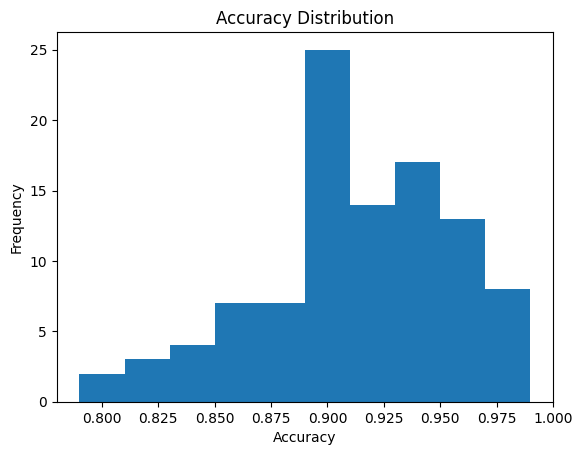

In [24]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

class FeatureSelector:
    def __init__(self, num_features):
        self.num_features = num_features  # Number of best features to select
        self.best_feature_ids = None  # To store the selected feature indices

    def fit(self, X, y):
        # Calculate the correlation between features and the target variable
        correlations = np.corrcoef(X, y, rowvar=False)[:-1, -1]
        # Sort features by their absolute correlation values in descending order
        feature_ranking = np.argsort(np.abs(correlations))[::-1]
        # Select the top num_features features
        self.best_feature_ids = feature_ranking[:self.num_features]

    def transform(self, X):
        if self.best_feature_ids is not None:
            return X[:, self.best_feature_ids]
        else:
            raise ValueError("Call 'fit' first to select the best features")

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

def experiment():
    # Dataset generation
    num_features_total = 1000
    num_features_best = 100
    N = 100
    X = np.random.normal(size=(N, num_features_total))
    y = np.random.randint(2, size=N)

    # Feature selection
    X_best = FeatureSelector(num_features_best).fit_transform(X, y)

    # Simple classification model
    model = LinearSVC()

    # Estimating accuracy using cross-validation
    return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Accuracy Distribution')
plt.show()


## Task 1 (3 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

In [25]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Define the FeatureSelector class
class FeatureSelector:
    def __init__(self, num_features):
        self.n = num_features  # number of best features to select

    def fit(self, X, y):
        # Select features that describe the targets best, i.e., have
        # the highest correlation with them:
        covariance = ((X - X.mean(axis=0)) * (y[:, np.newaxis] - y.mean())).mean(axis=0)
        self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

    def transform(self, X):
        return X[:, self.best_feature_ids]

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

num_features_total = 1000
num_features_best = 100
N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimating accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"Cross-Validation (CV) score is {cv_score}")

# Calculate the accuracy on the same data using predictions
accuracy_on_same_data = accuracy_score(y, model.fit(X_best, y).predict(X_best))
print(f"Accuracy on the same data (in-sample) is {accuracy_on_same_data}")


Cross-Validation (CV) score is 0.85
Accuracy on the same data (in-sample) is 1.0


In the FeatureSelector class, you are selecting the best features based on their correlation with the target variable (y).

You then fit the FeatureSelector on the entire dataset (X) and select the best features.

After selecting the best features, you apply this transformation (X_best) and then perform cross-validation on it with the classification model.

The problem is that in the feature selection step, you are using information from the target variable y to select the best features. This creates data leakage, as you are using information from the target variable that you should not have in a real-world scenario. In a real-world scenario, the model should not have access to the target variable when selecting features, as it doesn't know the true labels.

The reason you're getting a high accuracy in cross-validation is that the feature selection process effectively handpicks the features that are most correlated with the random y labels you generated, leading to a model that appears to perform well on the same data that was used to select the features.

To avoid this issue, you should separate the feature selection step from the cross-validation process. You can use cross-validation for feature selection as well, making sure that each fold in cross-validation uses a separate subset of the data for feature selection, and the selected features are then used for model training and testing. This prevents data leakage and provides a more realistic estimate of your model's performance.

In this code, I use the SelectKBest class from scikit-learn to select the best features, and it's part of a pipeline with the classification model. This ensures that feature selection is done separately within each fold of the cross-validation process, avoiding data leakage.

## Task 2 (3 points)

Let's come back to Task 3 of Data Handling HW.
Build a model with KNeighborsClassifier to get a higher accuracy on 5-fold Cross Validation than you achieve using your previosly fitted model (you can just copy the params from the previous notebook).

Use `sklearn.model_selection.GridSearchCV` to find best parameters.  You may check the parameters'  description as follows:
``` python
help(KNeighborsClassifier)
```

In [26]:
!wget https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv

--2023-11-04 20:09:14--  https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘train.csv.2’

train.csv.2         100%[===================>]  58.89K  --.-KB/s    in 0.009s  

2023-11-04 20:09:14 (6.76 MB/s) - ‘train.csv.2’ saved [60302/60302]



In [27]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

data = pd.read_csv("train.csv", index_col='PassengerId')

In [20]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer

# Load the data
data = pd.read_csv("train.csv", index_col='PassengerId')

# Select a subset of numeric features (excluding non-numeric columns)
numeric_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
X = data[numeric_features]

# Define the target (y)
y = data['Survived']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Feature selection: Select the best numeric features
selector = SelectKBest(score_func=chi2, k=3)  # You can adjust 'k' as needed
X_train_selected = selector.fit_transform(X_train, y_train)

# Define the parameter grid to explore for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Create the Random Forest classifier model
rf_model = RandomForestClassifier(random_state=42)

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(random_state=42, **best_params)
best_rf_model.fit(X_train_selected, y_train)

# Feature selection for the test set
X_test_selected = selector.transform(X_test)

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test_selected)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters for Random Forest:", best_params)
print("Best Cross-Validation Score (Accuracy):", best_score)
print("Test Accuracy:", test_accuracy)


Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Score (Accuracy): 0.7036540923864868
Test Accuracy: 0.7486033519553073


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for KNeighborsClassifier
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2]  # Power parameter for Minkowski distance
}

# Create a KNeighborsClassifier model
knn_model = KNeighborsClassifier()

# Use GridSearchCV to find the best parameters
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid_search.fit(X_train_selected, y_train)

# Get the best parameters and the best score
best_knn_params = knn_grid_search.best_params_
best_knn_score = knn_grid_search.best_score_

# Train the KNeighborsClassifier model with the best parameters
best_knn_model = KNeighborsClassifier(**best_knn_params)
best_knn_model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_knn_pred = best_knn_model.predict(X_test_selected)

# Calculate accuracy on the test set
test_knn_accuracy = accuracy_score(y_test, y_knn_pred)

print("Best Parameters for KNeighborsClassifier:", best_knn_params)
print("Best Cross-Validation Score (Accuracy) for KNeighborsClassifier:", best_knn_score)
print("Test Accuracy for KNeighborsClassifier:", test_knn_accuracy)


Best Parameters for KNeighborsClassifier: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best Cross-Validation Score (Accuracy) for KNeighborsClassifier: 0.6854525755934207
Test Accuracy for KNeighborsClassifier: 0.6703910614525139
